In [1]:
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings 
# silence warnings
warnings.filterwarnings("ignore")

from concurrent.futures import ThreadPoolExecutor
import os
from os import path
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.animation as animation
from matplotlib import rc

import numpy as np
import numpy.ma as ma

from scipy.ndimage.filters import gaussian_filter

import metpy.calc as mpcalc
from metpy.units import units as units

from IPython.display import clear_output

import pygrib

import requests

In [3]:
_INITDATE = '20221203'
_INITHOUR = '18'
start_frame = 12
num_frames = 1
sector = 'Conus'

anim_file_name = sector + '_' + _INITDATE + '-' + _INITHOUR + 'ZF{:02}-F{:02}'.format(start_frame,start_frame + num_frames -1) + '.' + str(os.getpid()) + '.hrefv3.gif'

# HREFv3.1
url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/href/v3.1/href.' + _INITDATE + '/ensprod/'
#url = 'https://ftpprd.ncep.noaa.gov/data/nccf/com/href/v3.1/href.' + _INITDATE + '/ensprod/'
# HREF Prod
#url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/href/prod/href.' + _INITDATE + '/ensprod/'
#url = 'https://ftpprd.ncep.noaa.gov/data/nccf/com/href/prod/href.' + _INITDATE + '/ensprod/'

data_crs = ccrs.PlateCarree()
map_crs = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35, standard_parallels = [30, 60])

sectors = {
    'Conus': {'bounds': [-125.5, -70.5, 23.5, 51.5], 'figsize': (16, 9.5), 'counties': False}
}

bounds = sectors[sector]['bounds']
figsize = sectors[sector]['figsize']
counties = sectors[sector]['counties']

In [4]:
def init():    
    # does nothing, for now - prevents animation.FuncAnimation() from drawing an initial frame
    pass

In [5]:
def get_grib(fname):
    """Download GRIB file"""
    
    if not path.exists(fname):
        try:
            req = requests.get(url + fname)
            with open(fname, 'wb') as file:
                file.write(req.content)
        except:
            print('Error: ', sys.exc_info()[0])
            raise

In [6]:
def add_borders(ax, **kwargs):
    """Render geoms
        Parameters
        ----------
        ax : Axes
            Axes to render on.
        **kwargs
            Passed on to `add_geometries`.
            eg `facecolor = 'None', edgecolor = 'w'`
    """
    
    # Draw states
    shape_file = shpreader.natural_earth(
        resolution = '10m', 
        category = 'cultural', 
        name = 'admin_1_states_provinces'
    )
    reader = shpreader.Reader(shape_file)
    states = reader.records()    
    for state in states:
        if state.attributes['adm0_a3'] == 'USA':
            ax.add_geometries(
                [state.geometry], ccrs.PlateCarree(), **kwargs
            )
            
    ax.add_feature(cfeature.LAKES.with_scale('10m'),
                   facecolor='None',
                   edgecolor='w',
                   zorder=20,
                   linewidth=.6,
                   alpha=0.8)
        
    # Draw countries
    shape_file = shpreader.natural_earth(
        resolution = '10m',
        category = 'cultural',
        name = 'admin_0_countries'
    )
    reader = shpreader.Reader(shape_file)
    countries = reader.records()    
    for country in countries:
        if country.attributes['ADM0_A3'] != 'USA':
            ax.add_geometries(
                [country.geometry], ccrs.PlateCarree(), **kwargs
            )

In [7]:
def update_progress(progress):
    bar_length = num_frames
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [8]:
def hght500_wspd500_mslp(n):
    
    current_frame = start_frame + n

    # Get the GRIBS
    mean_fname = 'href.t{}z.conus.mean.f{:02}.grib2'.format(_INITHOUR, current_frame)
    get_grib(mean_fname)
   
    # Mean GRIB
    mean_grib = pygrib.open(mean_fname)
    mean_grib.seek(0)
    hght_500 = units.meter * mean_grib.select(name = 'Geopotential Height', level = 500)[0].values
    uwnd_500 = units('m/s') * mean_grib.select(name = 'U component of wind', level = 500)[0].values
    vwnd_500 = units('m/s') * mean_grib.select(name = 'V component of wind', level = 500)[0].values
    mslp = units.hPa * mean_grib.select(name = 'MSLP (Eta model reduction)')[0].values
    lats, lons = mean_grib.select(name = 'MSLP (Eta model reduction)')[0].latlons()
    datadate = mean_grib.select(name = 'MSLP (Eta model reduction)')[0].analDate
    validdate = mean_grib.select(name = 'MSLP (Eta model reduction)')[0].validDate
    mean_grib.close()
    
    # Mask the wind fields below the upper 1/3 of windspeed
    wspd_500 = gaussian_filter(mpcalc.wind_speed(uwnd_500, vwnd_500), 5)
    mask_500 = ma.masked_less_equal(wspd_500, 0.66 * np.max(wspd_500)).mask
    uwnd_500[mask_500] = np.nan
    vwnd_500[mask_500] = np.nan

    # Create the plot
    plt.clf()
    ax = fig.add_subplot(projection = map_crs, facecolor = 'k')
    ax.set_extent(bounds, data_crs)
        
    # Activate defaults for plots
    plt.rcParams.update({        
        "font.sans-serif": "CMU Sans Serif",
        "font.family": "sans-serif"
    })
    
    # 500mb Height
    cont = ax.contour(lons,
                      lats,
                      mpcalc.smooth_n_point(hght_500/10, n = 9, passes = 4),
                      levels = range(504, 600, 6), 
                      colors = 'r',
                      linewidths = 1,
                      transform = data_crs)
    cont.clabel(inline = True,
                use_clabeltext = True,
                fmt = '%i',
                colors = 'r',
                rightside_up = True,
                inline_spacing = 2)
    [txt.set_fontproperties(dict(size = 'small', weight = 'bold')) for txt in cont.labelTexts]
    [txt.set_bbox(dict(facecolor = 'k', edgecolor = 'none', pad = 2)) for txt in cont.labelTexts]

    # 500mb Jet
    skip_500 = (slice(None, None, 33), slice(None, None, 33))
    jet_500 = ax.barbs(lons[skip_500],
                       lats[skip_500],
                       uwnd_500[skip_500].to('kt').m,
                       vwnd_500[skip_500].to('kt').m,
                       color = 'r',
                       length = 6,
                       pivot = 'middle',
                       transform = data_crs)

    # MSLP
    cont = ax.contour(lons,
                      lats,
                      mpcalc.smooth_n_point(mslp/100, 9, 4),
                      transform = data_crs,
                      levels = range(968, 1059, 2),
                      colors = 'y',
                      linewidths = 1)
    cont.clabel(inline = True,
                inline_spacing = .1,
                fmt = '%i',
                rightside_up = True,
                colors = 'y',
                use_clabeltext = True,
                levels = cont.levels[::2])
    [txt.set_fontproperties(dict(size = 'small', weight = 'bold')) for txt in cont.labelTexts]
    [txt.set_ha('center') for txt in cont.labelTexts]
    [txt.set_bbox(dict(facecolor = 'k', edgecolor = 'none', pad = .1)) for txt in cont.labelTexts]

    # MSLP high/low extrema
    fontdict1 = {'family': 'serif', 'weight': 'heavy', 'size': 'x-large', 'style': 'oblique'}    
    fontdict2 = {'family': 'serif', 'weight': 'heavy', 'size': 'large', 'style': 'oblique'}
    max_slp = np.amax(mslp)
    mxy, mxx = np.where(mslp == max_slp)
    ax.text(lons[mxy[0], mxx[0]], lats[mxy[0], mxx[0]],
            'H',
            color = 'skyblue',
            fontdict = fontdict1,
            bbox = dict(boxstyle = 'circle', fill = False, edgecolor = "skyblue", lw = 2),
            horizontalalignment = 'center',
            verticalalignment = 'center',
            transform = data_crs,
            zorder = 25)
    ax.text(lons[mxy[0], mxx[0]], lats[mxy[0], mxx[0]],
            '\n' + str(round(mslp[mxy[0], mxx[0]].m/100)),
            color = 'skyblue',
            fontdict = fontdict2,
            horizontalalignment = 'center',
            verticalalignment = 'top',
            transform = data_crs,
            zorder = 25)
        
    min_slp =np.amin(mslp)
    mxy, mxx = np.where(mslp == min_slp)
    ax.text(lons[mxy[0], mxx[0]], lats[mxy[0], mxx[0]], 'L', fontdict = fontdict1, bbox=dict(boxstyle='circle', fill=False, ec="red", lw = 2), color = 'red', zorder = 25,
            horizontalalignment = 'center', verticalalignment = 'center', transform = data_crs)
    ax.text(lons[mxy[0], mxx[0]], lats[mxy[0], mxx[0]], '\n' + str(round(mslp[mxy[0], mxx[0]].m/100)), fontdict = fontdict2, color = 'red', zorder = 25,
            horizontalalignment = 'center', verticalalignment = 'top', transform = data_crs)
    
    # Geo borders
    add_borders(ax, facecolor = 'None', edgecolor = 'w', linewidth = .6, alpha = 0.8, zorder = 20)
    if counties:
        ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor = 'whitesmoke', zorder = 20, alpha = 0.4, linewidth = .2) 
    ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor = 'None', edgecolor = 'w', zorder = 20, linewidth = .6, alpha = 0.8)
        
    # Plot the Legend
    gpm_500 = lines.Line2D([], [], color = 'r', label = 'Ens Mean 500 hPa Geopotential Height (dam)')
    jet_500 = mpatches.Patch(color = 'r', label = 'Ens Mean 500 hPa Jet (Kt)')
    eta_slp = lines.Line2D([], [], color='y', label = 'Ens Mean MSLP (hPa)', linewidth = 1)
    handles = [gpm_500, jet_500, eta_slp]
    legend = ax.legend(handles = handles, loc = 'lower right',
                       labelcolor = 'w', prop=dict(size = 'large'), edgecolor = 'w') 
    legend.set(zorder = 21)
    legend.get_frame().set_facecolor('k')
   
    # Plot titles
    ax.set_title(r'HREF (Init: {:s})'.format(datadate.isoformat(timespec = 'hours')), 
                 fontsize = 'large', loc = 'left', color = 'black')
    ax.set_title(r'F{:02} - Valid: {:s}'.format(current_frame, (validdate).isoformat(timespec = 'hours')),
                 fontsize = 'large', loc = 'right', color = 'black')
    
    # Adjust plot
    ax.set_aspect(aspect = 'auto', anchor = 'C')  
    
    fig.subplots_adjust(left = .009, 
                        bottom = .009, 
                        right = .99, 
                        top = .97, 
                        wspace = None, 
                        hspace = None)
    
    # Update progress bar
    update_progress((n+1)/num_frames)

Progress: [#] 100.0%

         94591320 function calls (93801733 primitive calls) in 665.558 seconds

   Ordered by: cumulative time, internal time
   List reduced from 4687 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     21/1    0.002    0.000  665.582  665.582 {built-in method builtins.exec}
        1    0.021    0.021  665.580  665.580 <string>:1(<module>)
        1    0.000    0.000  654.992  654.992 animation.py:974(save)
       10    0.000    0.000  570.976   57.098 animation.py:1172(_draw_next_frame)
       10    0.108    0.011  425.376   42.538 animation.py:1715(_draw_frame)
       10    0.338    0.034  425.266   42.527 <ipython-input-19-b4713114de34>:1(draw_frame)
1041472/1035810    2.871    0.000  335.138    0.000 {built-in method numpy.array}
267286/261907    0.141    0.000  333.160    0.001 _asarray.py:14(asarray)
      809    0.001    0.000  332.150    0.411 variable.py:509(values)
      809    0.003    0.000  332

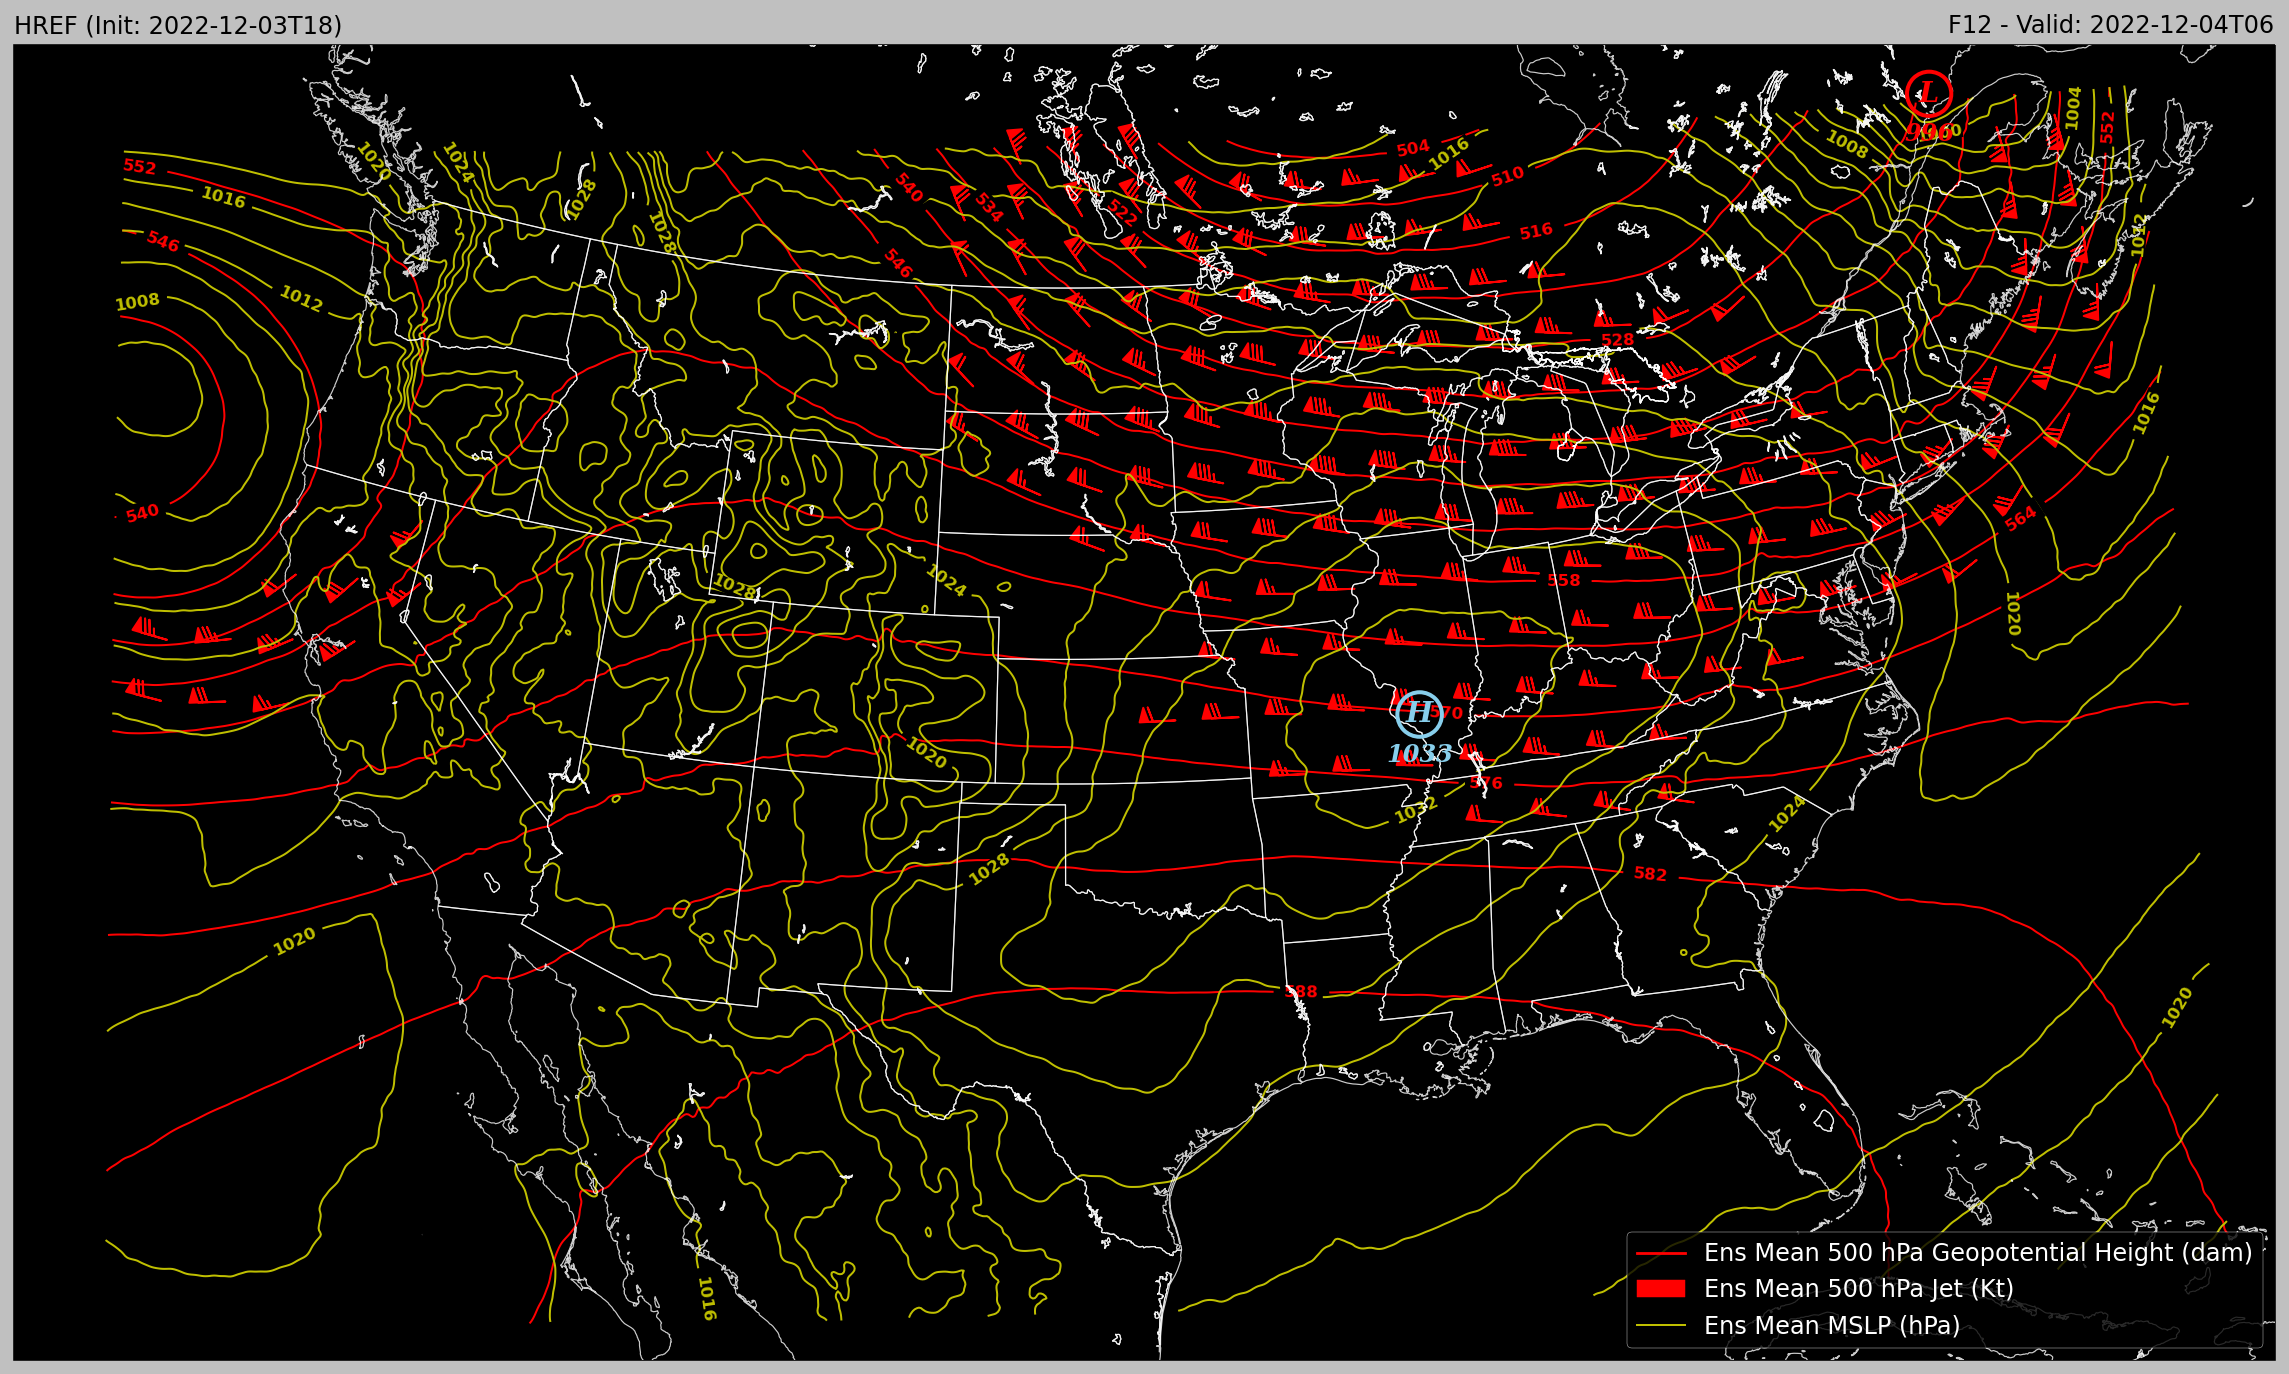

In [9]:
%%time
if __name__ == '__main__':

    plt.style.use('seaborn-paper')
    fig = plt.figure(1, figsize = figsize, facecolor = 'silver', edgecolor = 'darkgrey')

    anim = animation.FuncAnimation(fig, 
                                   hght500_wspd500_mslp,
                                   frames = num_frames, 
                                   init_func = init,
                                   repeat_delay = 5000)

    writergif = animation.PillowWriter(fps = 1)
    anim.save(anim_file_name, 
              writer = writergif)
    print('\n' + open('prun0', 'r').read())